In [2]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from htmldate import find_date
from util.api import get_lts_list

%matplotlib inline
plt.style.use('classic')

In [ ]:
lts_list = get_lts_list()
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)

def bytesto(bytes, to, bsize=1024):
    units_to_convert = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    size = float(bytes)
    for i in range(units_to_convert[to]):
        size = size / bsize

    return(size)# RQ0. Distribution
​
In this section, we respond the following two questions:
​
- How are packages distributed in stackage?
- How are packages using mtl distributed in Stackage?
​
For this, we make the following graphs
​
1. Line graph that shows the number of packets for each published snapshot over time
2. Bar graph that shows the evolution of the main categories of the packages
3. Bar graph that shows the evolution of the stabilities of the packages
4. Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`
5. Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`
​
## RQ0. 1 - Line graph that shows the number of packets for each published snapshot over time

In [3]:
def bytesto(bytes, to, bsize=1024):
    units_to_convert = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    size = float(bytes)
    for i in range(units_to_convert[to]):
        size = size / bsize

    return(size)

In [4]:
import re
def read_lines_code(fullpath):
    line_of_code = 0
    still_comment = 0
    file = open(fullpath,'r',encoding='latin-1')
    for idx,line in enumerate(file):
        no_space = line.strip()
        if no_space:
            
            big_comment = re.match("^({-[^#]*$)", no_space)
            if big_comment:
                still_comment += 1
                
            end_big_comment = re.match("[^#]*-}$", no_space)
            if end_big_comment:
                still_comment -= 1
                continue
            
            if still_comment != 0:
                continue
               
            comment = re.match("^\--+", no_space)
            if not comment and still_comment == 0:
                line_of_code += 1
                
    return line_of_code

In [5]:
list_size = []
for idx,lts in enumerate(lts_list):
    size = 0
    folderpath = f'C:/Users/nicol/Desktop/lts/lts-{lts}'
    
    for path, dirs, files in os.walk(folderpath):
        for f in files:
            if f.lower().endswith('.hs'):
                fp = os.path.join(path, f)
                try:
                    size += read_lines_code(fp)
                except Exception as e:
                    print('File ',fp,' with error: ',e)
    #Transform to MegaBytes          
    print("Folder LTS-" +str(lts)+ " size: " + str(size)+" LOC")
    list_size.append(size)

Folder LTS-0-7 size: 1109053 LOC
Folder LTS-2-22 size: 1642198 LOC
Folder LTS-3-22 size: 1855296 LOC
Folder LTS-6-35 size: 2931033 LOC
Folder LTS-7-24 size: 3456267 LOC
Folder LTS-9-21 size: 4007625 LOC
Folder LTS-11-22 size: 3719291 LOC
Folder LTS-12-14 size: 3682947 LOC
Folder LTS-12-26 size: 3775991 LOC
Folder LTS-13-11 size: 3271982 LOC
Folder LTS-13-19 size: 3476339 LOC
Folder LTS-14-27 size: 3598726 LOC
Folder LTS-15-3 size: 3579158 LOC
Folder LTS-16-11 size: 4179398 LOC
Folder LTS-16-31 size: 4076477 LOC
Folder LTS-17-2 size: 4156287 LOC
Folder LTS-18-6 size: 4552534 LOC
Folder LTS-18-8 size: 4553867 LOC
Folder LTS-18-18 size: 4555352 LOC


In [11]:
total_pkgs = [len(df) for df in df_list]
lts_datetim=[]
for lts in lts_list:
    url = f"https://www.stackage.org/lts-{lts.replace('-','.')}"
    response = requests.get(url)
    my_date = find_date(response.content, extensive_search=True)
    date_time_obj = datetime.fromisoformat(my_date)
    lts_datetim.append(date_time_obj)
    
lts_date = ["2014-12"]
dates = [datetime(2014,12,1)]
year = 2015
for i in range (7):
    month = 0
    for i in range (4):
        month += 3
        date = str(year)+"-"+str(month)
        formato = datetime(year,month,1)
        lts_date.append(date)
        dates.append(formato)
    year += 1
    
dates = matplotlib.dates.date2num(dates)

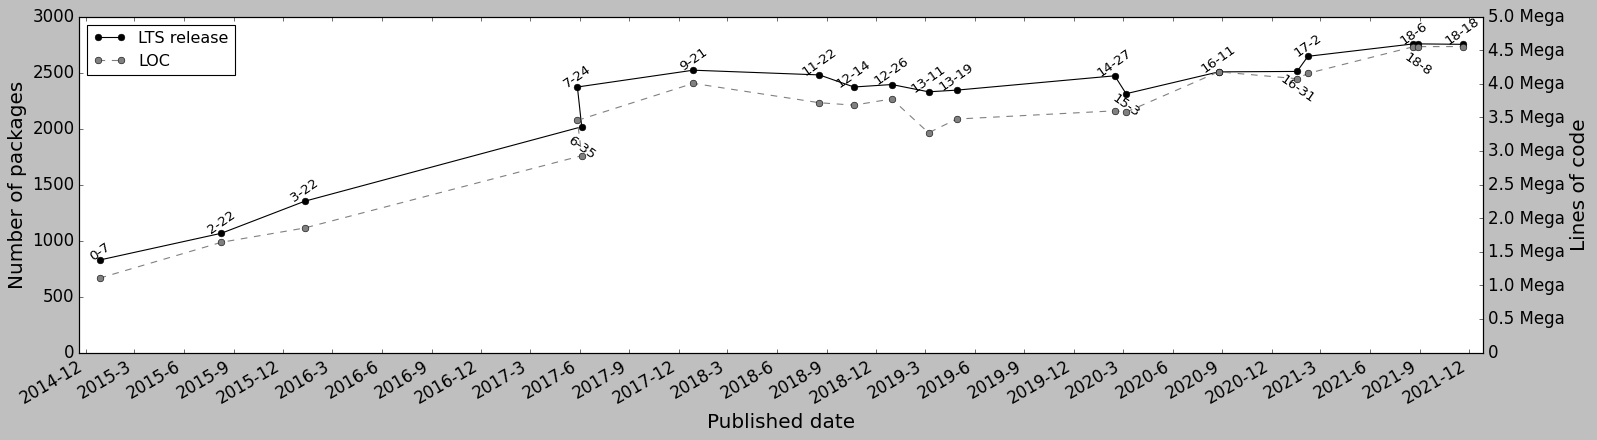

In [35]:
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(18,6))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)


#line = ax.plot(dates, total_pkgs, color='grey', marker='o',label='lts version')
lns1 = ax.plot_date(lts_datetim, total_pkgs, linestyle='solid',color='black',label='LTS release')
plt.gcf().autofmt_xdate()

for i in range(len(lts_list)):
    if i == 3 or i == 17 or i == 14:
        plt.text(lts_datetim[i],total_pkgs[i]-280,lts_list[i],ha="center",rotation = -35)
    elif i== 12:
        plt.text(lts_datetim[i],total_pkgs[i]-200,lts_list[i],ha="center",rotation = -35)
    else:
        plt.text(lts_datetim[i],total_pkgs[i],lts_list[i],ha="center",rotation = 35)
    
ax2 = ax.twinx()
lns2 = ax2.plot_date(lts_datetim, list_size, linestyle='--',color='grey',label='LOC')

ax.set_yticks([0,500, 1000, 1500, 2000, 2500, 3000])
ax.set_yticklabels(['0','500', '1000', '1500', '2000', '2500', '3000'],fontsize=15)

ax2.set_yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000,4000000,4500000,5000000])
ax2.set_yticklabels(['0', '0.5 Mega','1.0 Mega', '1.5 Mega', '2.0 Mega', '2.5 Mega', '3.0 Mega', '3.5 Mega', '4.0 Mega', '4.5 Mega','5.0 Mega'],fontsize=15)

ax.set_xticks(dates)
ax.set_xticklabels(lts_date,fontsize=15)

ax.set_xlabel('Published date',fontsize=18)
ax.set_ylabel('Number of packages',fontsize=18)
ax2.set_ylabel('Lines of code',fontsize=18)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')

plt.savefig("../../graphs/rq0-1.pdf", format='pdf', bbox_inches='tight')
plt.show()